In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv("T1.csv", parse_dates=['Date/Time'])
df = df.sort_values('Date/Time').reset_index(drop=True)

# Target
target_col = 'LV ActivePower (kW)'

# Fonction pour créer les séries temporelles avec une fenêtre glissante
def create_lag_features(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[target].values[i-window_size:i])
        y.append(data[target].values[i])
    return np.array(X), np.array(y)


R² Univariate: 0.9463


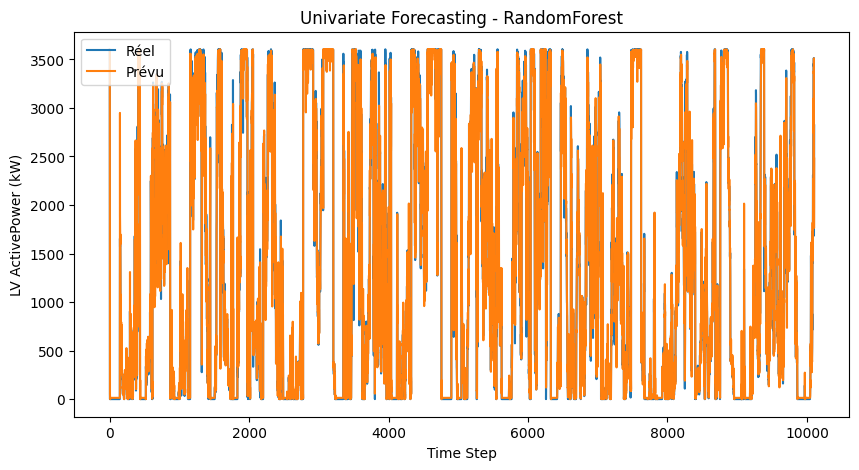

R² Univariate: 0.9463


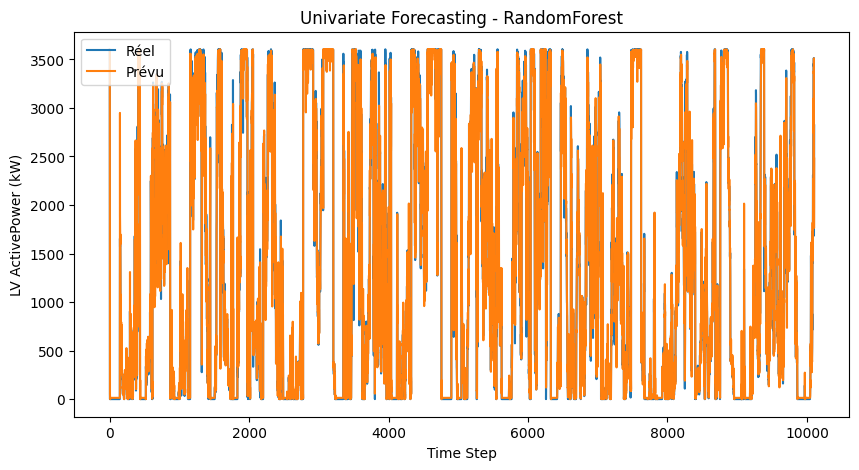

In [ ]:
# Paramètre : taille de la fenêtre
window_size = 5  # tu peux changer# Paramètre : taille de la fenêtre
  # tu peux changer
X_uni, y_uni = create_lag_features(df, target_col, window_size)

# Split train/test
split_idx = int(len(X_uni)*0.8)
X_train, X_test = X_uni[:split_idx], X_uni[split_idx:]
y_train, y_test = y_uni[:split_idx], y_uni[split_idx:]

# Modèle
rf_uni = RandomForestRegressor(n_estimators=100, random_state=42)
rf_uni.fit(X_train, y_train)

# Prédiction
y_pred_uni = rf_uni.predict(X_test)

# Évaluation
r2_uni = r2_score(y_test, y_pred_uni)
print(f"R² Univariate: {r2_uni:.4f}")

# Courbe d'amélioration
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label="Réel")
plt.plot(range(len(y_test)), y_pred_uni, label="Prévu")
plt.title("Univariate Forecasting - RandomForest")
plt.xlabel("Time Step")
plt.ylabel(target_col)
plt.legend()
plt.show()



R² Multivariate: 0.9493


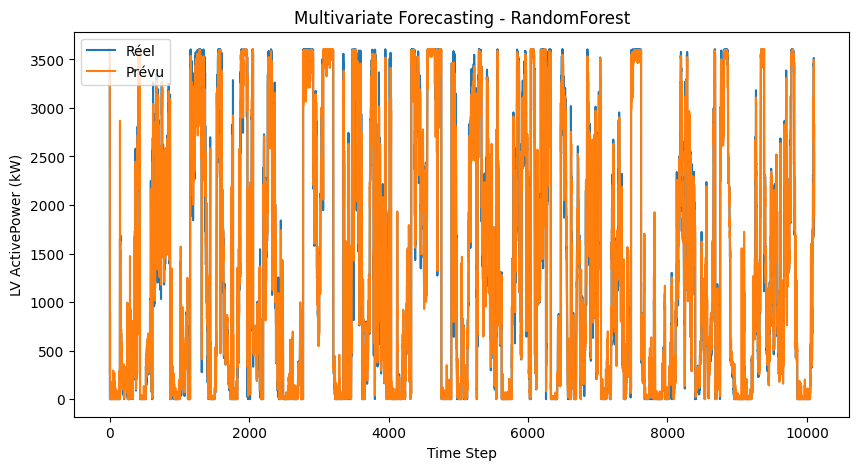

In [7]:
# Colonnes pour le multivariate
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

def create_multivariate_features(data, features, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        window_data = data[features].iloc[i-window_size:i].values.flatten()
        X.append(window_data)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

X_multi, y_multi = create_multivariate_features(df, features, target_col, window_size)

# Split train/test
X_train_m, X_test_m = X_multi[:split_idx], X_multi[split_idx:]
y_train_m, y_test_m = y_multi[:split_idx], y_multi[split_idx:]

# Modèle
rf_multi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_multi.fit(X_train_m, y_train_m)

# Prédiction
y_pred_multi = rf_multi.predict(X_test_m)

# Évaluation
r2_multi = r2_score(y_test_m, y_pred_multi)
print(f"R² Multivariate: {r2_multi:.4f}")

# Courbe d'amélioration
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test_m)), y_test_m, label="Réel")
plt.plot(range(len(y_test_m)), y_pred_multi, label="Prévu")
plt.title("Multivariate Forecasting - RandomForest")
plt.xlabel("Time Step")
plt.ylabel(target_col)
plt.legend()
plt.show()


R² Univariate: 0.9481


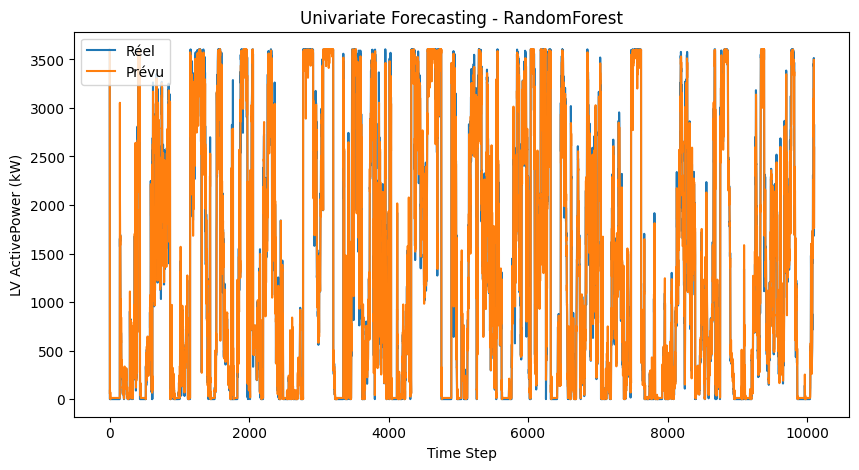

In [8]:
window_size = 12

X_uni, y_uni = create_lag_features(df, target_col, window_size)

# Split train/test
split_idx = int(len(X_uni)*0.8)
X_train, X_test = X_uni[:split_idx], X_uni[split_idx:]
y_train, y_test = y_uni[:split_idx], y_uni[split_idx:]

# Modèle
rf_uni = RandomForestRegressor(n_estimators=100, random_state=42)
rf_uni.fit(X_train, y_train)

# Prédiction
y_pred_uni = rf_uni.predict(X_test)

# Évaluation
r2_uni = r2_score(y_test, y_pred_uni)
print(f"R² Univariate: {r2_uni:.4f}")

# Courbe d'amélioration
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label="Réel")
plt.plot(range(len(y_test)), y_pred_uni, label="Prévu")
plt.title("Univariate Forecasting - RandomForest")
plt.xlabel("Time Step")
plt.ylabel(target_col)
plt.legend()
plt.show()


In [9]:
def predict_future(model, data, target, window_size, n_steps):
    """
    Prédit les n_steps prochains points avec un modèle RandomForest
    Args:
        model : RandomForestRegressor entraîné
        data : dataframe ou array des valeurs de la target
        target : nom de la colonne target
        window_size : taille de la fenêtre utilisée pour le modèle
        n_steps : nombre de points à prédire à la suite
    Returns:
        predictions : liste des valeurs prédites
    """
    # Récupérer les dernières valeurs connues pour commencer la prédiction
    last_window = data[target].values[-window_size:].tolist()
    predictions = []

    for _ in range(n_steps):
        X_input = np.array(last_window[-window_size:]).reshape(1, -1)  # forme (1, window_size)
        y_pred = model.predict(X_input)[0]
        predictions.append(y_pred)
        last_window.append(y_pred)  # ajouter la prédiction pour la prochaine étape

    return predictions


n_steps = 4
future_preds = predict_future(rf_uni, df, target_col, window_size, n_steps=4)

print(f"Les {n_steps} prochains points prédits :", future_preds)

Les 4 prochains points prédits : [2694.7308605957023, 2633.0332727050777, 2668.126096191406, 2528.2040714263903]


In [10]:
def predict_and_evaluate(model, data, target, window_size, n_steps):
    """
    Prédit les n_steps prochains points et calcule le R² par rapport aux valeurs réelles
    Args:
        model : RandomForestRegressor entraîné
        data : dataframe avec la colonne target
        target : nom de la colonne target
        window_size : taille de la fenêtre
        n_steps : nombre de points à prédire
    Returns:
        predictions : liste des valeurs prédites
        r2 : R² par rapport aux valeurs réelles
    """
    # Les dernières valeurs connues pour commencer la prédiction
    last_window = data[target].values[-window_size-n_steps:-n_steps].tolist()  # window avant n_steps
    real_values = data[target].values[-n_steps:]  # valeurs réelles à comparer
    predictions = []

    for _ in range(n_steps):
        X_input = np.array(last_window[-window_size:]).reshape(1, -1)
        y_pred = model.predict(X_input)[0]
        predictions.append(y_pred)
        last_window.append(y_pred)

    r2 = r2_score(real_values, predictions)
    return predictions, r2
n_steps = 4
future_preds, r2_future = predict_and_evaluate(rf_uni, df, target_col, window_size, n_steps)

print(f"Les {n_steps} prochains points prédits :", future_preds)
print(f"R² pour ces {n_steps} points :", r2_future)

Les 4 prochains points prédits : [2766.628010253905, 2780.938356666564, 2706.7568481445305, 2741.120817871093]
R² pour ces 4 points : -1.1956373613765052


In [11]:
def evaluate_multi_step(model, X_test, y_test, n_steps, window_size):
    """
    Évalue le modèle RandomForest sur le test set en prédisant n_steps à la suite
    Args:
        model : RandomForestRegressor entraîné
        X_test : fenêtres du test set (shape: num_samples x window_size)
        y_test : valeurs réelles correspondantes
        n_steps : nombre de points à prédire à la suite
        window_size : taille de la fenêtre
    Returns:
        r2_scores : liste des R² pour chaque position possible
        avg_r2 : R² moyen
    """
    r2_scores = []
    num_samples = len(X_test) - n_steps + 1  # nombre de positions possibles

    for i in range(num_samples):
        last_window = X_test[i].tolist()  # fenêtre initiale
        true_values = y_test[i:i+n_steps]  # valeurs réelles pour ces n_steps
        preds = []

        for _ in range(n_steps):
            X_input = np.array(last_window[-window_size:]).reshape(1, -1)
            y_pred = model.predict(X_input)[0]
            preds.append(y_pred)
            last_window.append(y_pred)  # ajout pour prédiction du point suivant

        r2 = r2_score(true_values, preds)
        r2_scores.append(r2)

    avg_r2 = np.mean(r2_scores)
    return r2_scores, avg_r2

# Évaluer le modèle sur 4 points à la suite
n_steps = 4
r2_list, avg_r2 = evaluate_multi_step(rf_uni, X_test, y_test, n_steps, window_size)

print(f"R² pour chaque position sur {n_steps} points :", r2_list[:10], "...")  # montrer les 10 premiers
print(f"R² moyen sur toutes les positions :", avg_r2)

R² pour chaque position sur 4 points : [-0.8669699491319598, -2.955184375806647, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ...
R² moyen sur toutes les positions : -1546214.349014398


In [12]:
def evaluate_multi_step(model, X_test, y_test, n_steps, window_size):
    """
    Évalue le modèle RandomForest sur le test set en prédisant n_steps à la suite
    Args:
        model : RandomForestRegressor entraîné
        X_test : fenêtres du test set (shape: num_samples x window_size)
        y_test : valeurs réelles correspondantes
        n_steps : nombre de points à prédire à la suite
        window_size : taille de la fenêtre
    Returns:
        r2_scores : liste des R² pour chaque position possible
        avg_r2 : R² moyen
    """
    r2_scores = []
    num_samples = len(X_test) - n_steps + 1  # nombre de positions possibles

    for i in range(num_samples):
        last_window = X_test[i].tolist()  # fenêtre initiale
        true_values = y_test[i:i+n_steps]  # valeurs réelles pour ces n_steps
        preds = []

        for _ in range(n_steps):
            X_input = np.array(last_window[-window_size:]).reshape(1, -1)
            y_pred = model.predict(X_input)[0]
            preds.append(y_pred)
            last_window.append(y_pred)  # ajout pour prédiction du point suivant

        r2 = r2_score(true_values, preds)
        r2_scores.append(r2)

    avg_r2 = np.mean(r2_scores)
    return r2_scores, avg_r2

# Évaluer le modèle sur 4 points à la suite
n_steps = 4
r2_list, avg_r2 = evaluate_multi_step(rf_multi, X_test_m, y_test_m, n_steps, window_size)

print(f"R² pour chaque position sur {n_steps} points :", r2_list[:10], "...")  # montrer les 10 premiers
print(f"R² moyen sur toutes les positions :", avg_r2)

ValueError: X has 12 features, but RandomForestRegressor is expecting 20 features as input.